# Data Source and goal of this case study

Data: https://www.kaggle.com/patrickb1912/ipl-complete-dataset-20082020  
          
Goal:   
    1. Identify cluster of players with similar performance  
    2. Given a player name, identify similar players  
    3. Create a best team with mix of batsman, bowler, allrounders & wicket-keeper
    

# Imports and data read

In [348]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.cluster import DBSCAN

In [349]:
balldf = pd.read_csv("data/IPL_2008_2020/IPL Ball-by-Ball 2008-2020.csv")

In [350]:
matches = pd.read_csv("data/IPL_2008_2020/IPL Matches 2008-2020.csv")

In [351]:
balldf.head(3)

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


In [352]:
matches.head(3)

,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
0,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,Chandigarh,2008-04-19,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,N,NaN,MR Benson,SL Shastri
2,335984,Delhi,2008-04-19,MF Maharoof,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,N,NaN,Aleem Dar,GA Pratapkumar


In [353]:
balldf.shape

(193468, 18)

In [354]:
matches.shape

(816, 17)

# Check Missing

In [355]:
balldf.isnull().sum()

id                       0
inning                   0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
batsman_runs             0
extra_runs               0
total_runs               0
non_boundary             0
is_wicket                0
dismissal_kind      183973
player_dismissed    183973
fielder             186684
extras_type         183235
batting_team             0
bowling_team           191
dtype: int64

The variables with missing data is not used to create the player statistics in this analysis and can be ignored.

# Create batsman statistics

## Variables by grouping on batsman

In [356]:
# Group details on batsmen
batgroup = balldf.groupby(['batsman'])

# Create a batting dataframe with a summary statistics for each batsman
batdf = pd.DataFrame(batgroup['ball'].count()).rename(columns={'ball':'balls_faced'})
batdf['innings'] = batgroup['id'].nunique()
batdf['runs'] = batgroup['batsman_runs'].sum()
batdf['4s'] = balldf[balldf['batsman_runs'] == 4].groupby('batsman')['batsman_runs'].count()
batdf['4s'].fillna(0,inplace=True)
batdf['6s'] = balldf[balldf['batsman_runs'] == 6].groupby('batsman')['batsman_runs'].count()
batdf['6s'].fillna(0,inplace=True)


## Derived variable - Batsman average & strike rate

In [357]:
# Batting average = total rus scored/no. of times batsman is been dismissed
# Approximated here to matches instead of no. of dismissals
batdf['bat_average'] = round(batdf['runs']/batdf['innings'],2)

In [358]:
# Strike Rate = (Runs Scored / Balls faced) * 100
batdf['bat_strike'] = round(batdf['runs']/batdf['balls_faced']*100,2)


In [359]:
display(batdf.tail())

,balls_faced,innings,runs,4s,6s,bat_average,bat_strike
batsman,,,,,,,
YV Takawale,183,10,192,26.0,3.0,19.20,104.92
Yashpal Singh,67,4,47,5.0,0.0,11.75,70.15
Younis Khan,7,1,3,0.0,0.0,3.00,42.86
Yuvraj Singh,2205,126,2750,217.0,149.0,21.83,124.72
Z Khan,141,27,117,11.0,2.0,4.33,82.98


# Create bowler statistics

## Variables by grouping on bowler

In [360]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [361]:
# Group details on bowler
bowlgroup = balldf.groupby(['bowler'])

# Create a bowling dataframe (bowldf) with a summary statistics for each batsman
bowldf = pd.DataFrame(bowlgroup['ball'].count()).rename(columns={'ball':'balls_bowled'})

# Get no. of wickets taken by each bowler
bwl_wkts = balldf[balldf['dismissal_kind'].isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket'])]
bowldf['wickets'] = bwl_wkts.groupby(['bowler'])['ball'].count()
bowldf['wickets'].fillna(0,inplace=True)
 
# Calculate the total no. of overs bowled
overs = pd.DataFrame(balldf.groupby(['bowler','id'])['over'].nunique())
bowldf['overs'] = overs.groupby(['bowler'])['over'].sum()    

# Calculate the runs conceded
bowldf['runs_conceded'] = balldf.groupby('bowler')['batsman_runs'].sum()
bowldf['runs_conceded'] = bowldf['runs_conceded'].fillna(0)
# Add the runs conceded through wide and noball
bowldf['runs_conceded'] = bowldf['runs_conceded'].add(balldf[balldf['extras_type'].isin(['wides','noballs'])].groupby('bowler')['extra_runs'].sum(),fill_value=0)

bowldf.head()


,balls_bowled,wickets,overs,runs_conceded
bowler,,,,
A Ashish Reddy,270,18.0,45,396.0
A Chandila,234,11.0,39,242.0
A Choudhary,108,5.0,17,144.0
A Dananjaya,25,0.0,4,47.0
A Flintoff,66,2.0,11,105.0


## Derived variable - Bowler econ rate

In [362]:
# Note - roughly apprx to overs.  Should be runs_conceded/overs.balls
bowldf['bowl_econ'] = round(bowldf['runs_conceded']/bowldf['overs'],2)

In [363]:
display(bowldf.tail())

,balls_bowled,wickets,overs,runs_conceded,bowl_econ
bowler,,,,,
YA Abdulla,222,15.0,35,307.0,8.77
YK Pathan,1184,42.0,193,1415.0,7.33
YS Chahal,2188,121.0,359,2723.0,7.58
Yuvraj Singh,882,36.0,146,1077.0,7.38
Z Khan,2276,102.0,371,2782.0,7.50


# Get all players list along with the matches count

Getting total no. of matches:  
- If the player's name occurs as batsman, non-striker or bowler consider the player has played that match  
- Note: this is a rough approximation for the matches played (there could be players who have played in the match but did not get a chance to bat or bowl in the match)


In [364]:
def update_player_with_match(player_name, id):
    if player_name in all_players_dict:
        all_players_dict[player_name].add(id)
    else:
        all_players_dict[player_name] = {id}
    
def update_player_list(x):
    update_player_with_match(x['batsman'],x['id'])
    update_player_with_match(x['non_striker'],x['id'])
    update_player_with_match(x['bowler'],x['id']) 
        


In [365]:
all_players_dict = {}
out_temp = balldf.apply(lambda x: update_player_list(x),axis=1)
all_df = pd.DataFrame({'Players':list(all_players_dict.keys())})
all_df['matches'] = all_df['Players'].apply(lambda x: len(all_players_dict[x]))
all_df=all_df.set_index('Players')

# Merged player statistics

In [366]:
# Combine the batting and bowling dataframes to create a merged players dataframe
players = pd.merge(all_df,batdf, left_index=True, right_index=True,how='outer')
players = pd.merge(players,bowldf, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

In [367]:
players.tail()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ
YV Takawale,10,183.0,10.0,192.0,26.0,3.0,19.20,104.92,0.0,0.0,0.0,0.0,0.00
Yashpal Singh,4,67.0,4.0,47.0,5.0,0.0,11.75,70.15,0.0,0.0,0.0,0.0,0.00
Younis Khan,1,7.0,1.0,3.0,0.0,0.0,3.00,42.86,0.0,0.0,0.0,0.0,0.00
Yuvraj Singh,129,2205.0,126.0,2750.0,217.0,149.0,21.83,124.72,882.0,36.0,146.0,1077.0,7.38
Z Khan,99,141.0,27.0,117.0,11.0,2.0,4.33,82.98,2276.0,102.0,371.0,2782.0,7.50


# Create no. of catches statistics

In [368]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [369]:
# Total catches = Number of caught & bowled + number of catches as fielder
# Capture caught & bowled instances
catches_cb = balldf[(balldf['dismissal_kind'].isin(['caught and bowled']))].groupby('bowler')['ball'].count().rename('bowler_catches')
# Capture the catches
catches_c = balldf[(balldf['dismissal_kind'].isin(['caught']))].groupby('fielder')['ball'].count().rename('fielder_catches')
# Combine the caught & bowled and fielding catches to get the total catches.
catches_df = pd.merge(catches_cb,catches_c, left_index=True, right_index=True,how='outer')
catches_df.fillna(0,inplace=True)
catches_df['catches'] = catches_df['bowler_catches']+catches_df['fielder_catches']
catches_df.drop(['bowler_catches','fielder_catches'],axis=1,inplace=True)
# Merge total catches to players data
players = pd.merge(players,catches_df, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

# Number of man of the  matches from matches file

In [370]:
players = pd.merge(players,matches['player_of_match'].value_counts(), left_index=True, right_index=True,how='left')
players['player_of_match']  = players[['player_of_match']].fillna(0)

In [371]:
players.head()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Chandila,12.0,7.0,2.0,4.0,0.0,0.0,2.00,57.14,234.0,11.0,39.0,242.0,6.21,7.0,1.0
A Chopra,6.0,75.0,6.0,53.0,7.0,0.0,8.83,70.67,0.0,0.0,0.0,0.0,0.00,2.0,0.0
A Choudhary,5.0,20.0,3.0,25.0,1.0,1.0,8.33,125.00,108.0,5.0,17.0,144.0,8.47,0.0,0.0
A Dananjaya,1.0,5.0,1.0,4.0,0.0,0.0,4.00,80.00,25.0,0.0,4.0,47.0,11.75,0.0,0.0


# Filtering: Remove players who have played less matches

In [372]:
# Backup before data filtering
all_players = players.copy()

ALL_COLUMN_NAMES = list(players.columns)

In [373]:
players.shape

(648, 15)

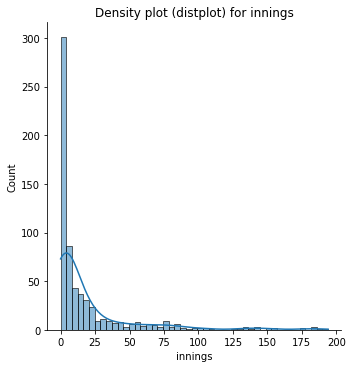

In [374]:
sns.displot(players['innings'],kde=True)
plt.title('Density plot (distplot) for innings')
plt.show()

In [375]:
players['innings'].describe()

count    648.000000
mean      18.768519
std       32.885716
min        0.000000
25%        1.000000
50%        5.000000
75%       19.000000
max      194.000000
Name: innings, dtype: float64

In [376]:
# Cut off on no. of matches

# Current Analysis: Players who have played atleast 10 matches
CUTOFF_MATCHES = 10
players=players[players['innings']>=CUTOFF_MATCHES]

In [377]:
players.shape

(251, 15)

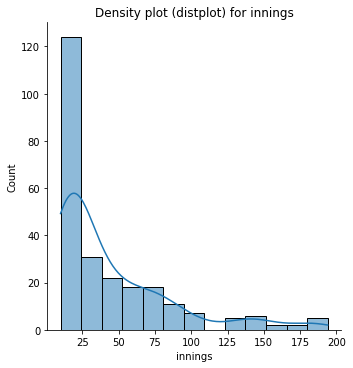

In [378]:
sns.displot(players['innings'],kde=True)
plt.title('Density plot (distplot) for innings')
plt.show()

# Explore the players data

In [379]:
players.head()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Kumble,42.0,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0
A Mishra,150.0,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3233.0,160.0,529.0,3867.0,7.31,21.0,11.0
A Nehra,88.0,63.0,17.0,41.0,3.0,1.0,2.41,65.08,1974.0,106.0,320.0,2495.0,7.80,19.0,6.0
A Symonds,36.0,781.0,36.0,974.0,74.0,41.0,27.06,124.71,540.0,20.0,88.0,674.0,7.66,21.0,3.0


<function matplotlib.pyplot.show(*args, **kw)>

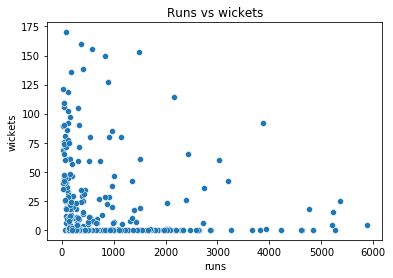

In [380]:
sns.scatterplot(data=players, x="runs", y="wickets")
plt.title("Runs vs wickets")
plt.show

# Scale the data

In [381]:
# Standard Scaler (mean = 0 and standard deviation = 1)
scaler = StandardScaler()

# fit_transform
players_scaled = pd.DataFrame(scaler.fit_transform(players),columns=players.columns)
players_scaled.shape
players_scaled.head()


# TESTING -  CONSIDER  ONLY RUNS AND WICKETS
#players_scaled  = players_scaled[['runs','wickets','catches']]

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
0,-0.681449,-0.586132,-0.514618,-0.537008,-0.596562,-0.394531,-0.476250,1.197842,-0.400299,-0.220922,-0.391620,-0.353023,0.772222,-0.561588,-0.755049
1,-0.363228,-0.746431,-0.707912,-0.743238,-0.710905,-0.698918,-1.604319,-2.082638,0.495151,0.507283,0.520538,0.320197,0.193070,-0.513659,0.003020
2,2.091618,-0.352772,0.234399,-0.467985,-0.482219,-0.597456,-1.103337,-1.308329,3.320906,3.608900,3.349777,3.176804,0.398656,0.013558,2.024537
3,0.682355,-0.731164,-0.659589,-0.738188,-0.710905,-0.678626,-1.595148,-2.374267,1.739740,2.152489,1.734173,1.781551,0.521507,-0.082300,0.761089
4,-0.499608,0.051791,-0.200514,0.047168,-0.086415,0.133073,1.230758,0.364289,-0.061208,-0.166981,-0.059223,-0.070311,0.486407,0.013558,0.003020


In [382]:
# Mean around ~0 and standard deviation ~1 in all the scaled columns
players_scaled.describe()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
count,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02,2.510000e+02
mean,-1.415424e-17,5.661695e-17,-3.538559e-18,-4.246271e-17,2.830848e-17,7.607903e-17,7.430975e-17,-1.698509e-16,5.750159e-17,-2.476992e-17,-1.769280e-17,-5.307839e-18,-7.784831e-17,4.157807e-17,5.130911e-17
std,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00,1.001998e+00
min,-1.090590e+00,-7.551544e-01,-8.287215e-01,-7.592314e-01,-7.372922e-01,-6.989182e-01,-1.775134e+00,-3.729996e+00,-7.393897e-01,-7.063928e-01,-7.394775e-01,-7.557342e-01,-1.434069e+00,-9.929471e-01,-7.550485e-01
25%,-8.178293e-01,-6.493792e-01,-6.837506e-01,-6.380189e-01,-6.405401e-01,-5.974558e-01,-7.892201e-01,-5.174868e-01,-7.393897e-01,-7.063928e-01,-7.394775e-01,-7.557342e-01,-1.434069e+00,-6.574456e-01,-6.287037e-01
50%,-3.177680e-01,-4.498239e-01,-4.662942e-01,-4.570419e-01,-4.558316e-01,-3.945310e-01,-1.518151e-01,1.461410e-01,-4.392317e-01,-4.906282e-01,-4.380013e-01,-4.313278e-01,4.462923e-01,-3.219440e-01,-2.496694e-01
75%,5.346092e-01,2.279009e-01,4.035312e-01,2.723374e-01,1.730569e-01,1.432196e-01,7.045546e-01,6.393841e-01,4.078669e-01,3.724304e-01,4.007210e-01,3.766374e-01,6.368355e-01,2.292371e-01,2.557098e-01
max,3.114471e+00,4.226096e+00,3.617053e+00,4.175127e+00,4.460933e+00,6.383156e+00,2.441369e+00,2.536119e+00,3.594691e+00,3.878606e+00,3.612602e+00,3.579515e+00,3.580227e+00,4.662650e+00,5.056812e+00


# update player name as column

In [383]:
players.insert(0, 'name', players.index)

In [384]:
players.head()

,name,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
A Ashish Reddy,A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Kumble,A Kumble,42.0,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0
A Mishra,A Mishra,150.0,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3233.0,160.0,529.0,3867.0,7.31,21.0,11.0
A Nehra,A Nehra,88.0,63.0,17.0,41.0,3.0,1.0,2.41,65.08,1974.0,106.0,320.0,2495.0,7.80,19.0,6.0
A Symonds,A Symonds,36.0,781.0,36.0,974.0,74.0,41.0,27.06,124.71,540.0,20.0,88.0,674.0,7.66,21.0,3.0


# Finding optimal no. of clusters (k)

## Elbow method

Steps in elbow method:
- Initialize k with a range of values for the no. of clusters.   
- For each value of k, 
    - perform the k-means clustering  
    - compute the sum of squared distances of samples to the nearest cluster centre
- Plot a graph of k versus the sum of squared distances


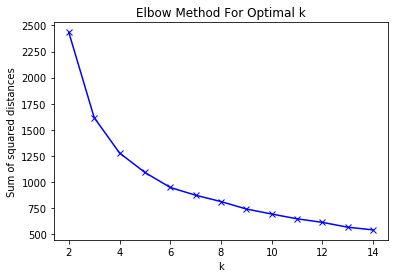

In [385]:
# Elbow-curve/sum of squared distances
sum_squared_distances = []
k_range = range(2,15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(players_scaled)
    
    sum_squared_distances.append(kmeans.inertia_)
    
# plot the SSDs for each k

plt.plot(k_range, sum_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()


Inference:
- As the no. of clusters (k) increases, the sum of squared distance tends to zero.   
- The plot of no. of clusters vs sum of squared distances will look like an arm. The elbow on the arm is optimal k.
- In the plot for the players dataset, the elbow is at k=5 indicating the optimal k for this dataset is 5

## Silhouette Analysis¶
silhouette score=(𝑝−𝑞)/𝑚𝑎𝑥(𝑝,𝑞)
 
𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of

𝑞  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [386]:
# silhouette analysis
k_range = range(2,15)

for k in k_range :
    # intialise kmeans
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(players_scaled)
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(players_scaled, cluster_labels)
    print(f"For k={k}, the silhouette score is {silhouette_avg}")
    
    

For k=2, the silhouette score is 0.4229780389226616
For k=3, the silhouette score is 0.4059024385404374
For k=4, the silhouette score is 0.3658360748244456
For k=5, the silhouette score is 0.3068387516391533
For k=6, the silhouette score is 0.30021355807939354
For k=7, the silhouette score is 0.2801912596790116
For k=8, the silhouette score is 0.30140348502205433
For k=9, the silhouette score is 0.2797432214663121
For k=10, the silhouette score is 0.2940969515842692
For k=11, the silhouette score is 0.2758781366959463
For k=12, the silhouette score is 0.2794383483183545
For k=13, the silhouette score is 0.2665276433352732
For k=14, the silhouette score is 0.26581046672454656


Inference:
- The best possible silhouette score is around 0.42
- The optimal no. of clusters could be 4 or 5

In [387]:
NUM_CLUSTERS = 5

# Utility Methods

In [388]:
players.head(2)

,name,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match
A Ashish Reddy,A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Kumble,A Kumble,42.0,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0


In [389]:
# Show the top few players in each cluster (Players sorted on no. of matches played)
def  groupby_cluster(cluster_col, head_size):
    g = players.groupby([cluster_col]).apply(lambda x: x.sort_values(["matches"], ascending = False)).reset_index(drop=True)
    # select top N rows within each cluster
    display(g.groupby(cluster_col)['name',cluster_col].head(head_size))

In [390]:
# Get the summary of the clustering based on the labels in the output column specified
def  clustering_summary(cluster_col):
    # Add prefix cluster to cluster numbers
    players[cluster_col]=players[cluster_col].apply(lambda x: x if str(x).startswith('Cluster ')  else  f'Cluster {str(x)}')
    # Create summary table for clusters
    cluster_summary = pd.DataFrame(players[cluster_col].value_counts().sort_index())
    cluster_summary.columns = ['Num_Players']

    # Plot pie-chart
    cluster_summary['Num_Players'].plot.pie()
    plt.show()
    # Print summary table
    display(cluster_summary)

    # Sort players data based on no. of innings played
    #players.sort_values(["innings"], ascending = False,inplace=True)
    # Create column for each cluster and insert players in that cluster
    grouper = players.sort_values(["innings"], ascending = False)[['name',cluster_col]].groupby([cluster_col])
    cluster_df = pd.concat([pd.Series(v['name'].tolist(), name=k) for k, v in grouper], axis=1)
    cluster_df.fillna('',inplace=True)
    display(cluster_df)
    return cluster_summary, cluster_df

In [391]:
def create_cluster_df(cluster_col):
    print(players.head())
    pass
    
    
# create_cluster_df("output_kmeans")    

# k-means Clustering

In [392]:
# Define function to perform the kmeans clustering on the given data
def kmeans_clustering(num_clusters, max_iterations,input_df,output_df, output_col):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=max_iterations)
    kmeans.fit(input_df)
    # assign the label to the output column
    output_df[output_col] = kmeans.labels_ 

In [393]:
# New output column to create for the cluster label
kmeans_label = 'cluster_kmeans'

# K-means clustering
kmeans_clustering(NUM_CLUSTERS,50,players_scaled[ALL_COLUMN_NAMES],players,kmeans_label)

# View few entries from each cluster
groupby_cluster(kmeans_label,3)


,name,cluster_kmeans
0,RA Jadeja,0
1,PP Chawla,0
2,Harbhajan Singh,0
39,PA Patel,1
40,MK Pandey,1
41,Yuvraj Singh,1
80,RG Sharma,2
81,SK Raina,2
82,V Kohli,2
96,STR Binny,3


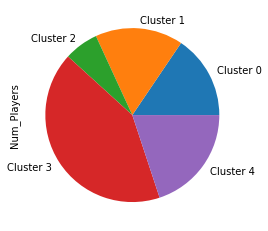

,Num_Players
Cluster 0,39
Cluster 1,41
Cluster 2,16
Cluster 3,105
Cluster 4,50


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,RA Jadeja,PA Patel,RG Sharma,STR Binny,KM Jadhav
1,DJ Bravo,MK Pandey,SK Raina,KH Pandya,SS Tiwary
2,Harbhajan Singh,Yuvraj Singh,V Kohli,LRPL Taylor,S Badrinath
3,IK Pathan,BB McCullum,RV Uthappa,Y Venugopal Rao,EJG Morgan
4,PP Chawla,M Vijay,MS Dhoni,AM Nayar,Ishan Kishan
5,AR Patel,V Sehwag,KD Karthik,DJ Hooda,M Vohra
6,JA Morkel,SV Samson,S Dhawan,TM Dilshan,CA Lynn
7,SP Narine,WP Saha,AB de Villiers,MC Henriques,MS Bisla
8,P Kumar,JH Kallis,YK Pathan,Shakib Al Hasan,PP Shaw
9,R Ashwin,NV Ojha,G Gambhir,CL White,Shubman Gill


(           Num_Players
 Cluster 0           39
 Cluster 1           41
 Cluster 2           16
 Cluster 3          105
 Cluster 4           50,
            Cluster 0         Cluster 1       Cluster 2        Cluster 3  \
 0          RA Jadeja          PA Patel       RG Sharma        STR Binny   
 1           DJ Bravo         MK Pandey        SK Raina        KH Pandya   
 2    Harbhajan Singh      Yuvraj Singh         V Kohli      LRPL Taylor   
 3          IK Pathan       BB McCullum      RV Uthappa  Y Venugopal Rao   
 4          PP Chawla           M Vijay        MS Dhoni         AM Nayar   
 5           AR Patel          V Sehwag      KD Karthik         DJ Hooda   
 6          JA Morkel         SV Samson        S Dhawan       TM Dilshan   
 7          SP Narine           WP Saha  AB de Villiers     MC Henriques   
 8            P Kumar         JH Kallis       YK Pathan  Shakib Al Hasan   
 9           R Ashwin           NV Ojha       G Gambhir         CL White   
 10          A Mish

In [394]:

# View the summary of the clustering
clustering_summary(kmeans_label)

# Hierarchical Clustering

## Dendogram

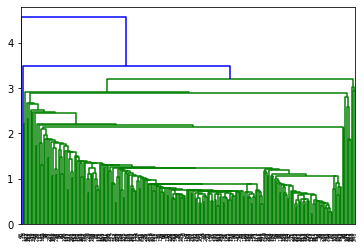

In [395]:
# single linkage
mergings = linkage(players_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

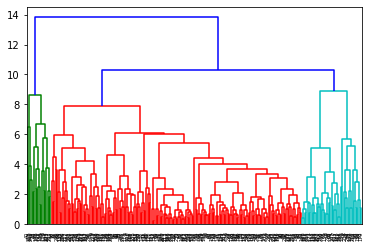

In [396]:
# complete linkage
mergings = linkage(players_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

## Hierarchical clustering

In [397]:
# Perform hierarchical clustering based on the input parameters
def hierarchical_clustering(linkage_method, linkage_metric, num_clusters,input_df,output_df,output_col):
    mergings = linkage(input_df, method=linkage_method, metric=linkage_metric)
    cluster_labels = cut_tree(mergings, n_clusters=num_clusters).reshape(-1, )
    # assign cluster labels
    output_df[output_col] = cluster_labels
    return mergings

In [398]:
# # Linkage method could be single, complete, average, weighted, centroid, median, ward
# # Refer to: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

# mergings = hierarchical_clustering(linkage_method = "complete", linkage_metric = "euclidean", num_clusters = NUM_CLUSTERS, input_df = players_scaled[ALL_COLUMN_NAMES], output_df = players, output_col = "cluster_hier")
# dendrogram(mergings)
# plt.show()

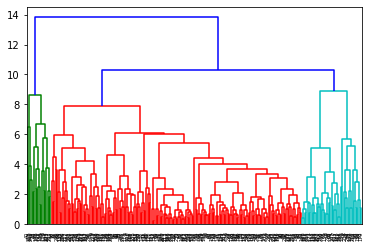

,name,cluster_hier
0,Yuvraj Singh,0
1,BB McCullum,0
2,M Vijay,0
188,Z Khan,1
189,YS Chahal,1
190,Sandeep Sharma,1
217,RA Jadeja,2
218,PP Chawla,2
219,Harbhajan Singh,2
233,RG Sharma,3


In [399]:
# New output column to create for the cluster label
hier_label = 'cluster_hier'


# Hierarchical clustering
# Linkage method could be single, complete, average, weighted, centroid, median, ward
# Refer to: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

mergings = hierarchical_clustering(linkage_method = "complete", linkage_metric = "euclidean", num_clusters = NUM_CLUSTERS, input_df = players_scaled[ALL_COLUMN_NAMES], output_df = players, output_col = "cluster_hier")
 
# Plot the dendogram
dendrogram(mergings)
plt.show()

# View few entries from each cluster
groupby_cluster(hier_label,3)

In [400]:
# # Create the cluster labels
# cluster_labels = cut_tree(mergings, n_clusters=NUM_CLUSTERS).reshape(-1, )# assign cluster labels
# players['cluster_hier'] = cluster_labels
# groupby_cluster("cluster_hier",2)

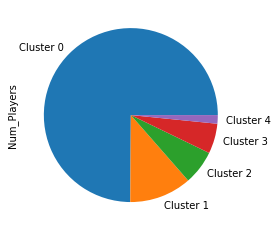

,Num_Players
Cluster 0,188
Cluster 1,29
Cluster 2,16
Cluster 3,14
Cluster 4,4


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,Yuvraj Singh,KV Sharma,RA Jadeja,RG Sharma,YK Pathan
1,BB McCullum,MG Johnson,DJ Bravo,SK Raina,KA Pollard
2,M Vijay,RP Singh,Harbhajan Singh,V Kohli,SR Watson
3,V Sehwag,SK Warne,IK Pathan,RV Uthappa,CH Gayle
4,SV Samson,Z Khan,PP Chawla,MS Dhoni,
5,WP Saha,MM Sharma,AR Patel,KD Karthik,
6,JH Kallis,Sandeep Sharma,JA Morkel,S Dhawan,
7,NV Ojha,DS Kulkarni,SP Narine,AB de Villiers,
8,Mandeep Singh,MJ McClenaghan,P Kumar,G Gambhir,
9,DR Smith,PP Ojha,R Ashwin,AT Rayudu,


(           Num_Players
 Cluster 0          188
 Cluster 1           29
 Cluster 2           16
 Cluster 3           14
 Cluster 4            4,
             Cluster 0       Cluster 1        Cluster 2       Cluster 3  \
 0        Yuvraj Singh       KV Sharma        RA Jadeja       RG Sharma   
 1         BB McCullum      MG Johnson         DJ Bravo        SK Raina   
 2             M Vijay        RP Singh  Harbhajan Singh         V Kohli   
 3            V Sehwag        SK Warne        IK Pathan      RV Uthappa   
 4           SV Samson          Z Khan        PP Chawla        MS Dhoni   
 5             WP Saha       MM Sharma         AR Patel      KD Karthik   
 6           JH Kallis  Sandeep Sharma        JA Morkel        S Dhawan   
 7             NV Ojha     DS Kulkarni        SP Narine  AB de Villiers   
 8       Mandeep Singh  MJ McClenaghan          P Kumar       G Gambhir   
 9            DR Smith         PP Ojha         R Ashwin       AT Rayudu   
 10           SA Yadav        

In [401]:
# View the summary of the clustering
clustering_summary(hier_label)

#  DBScan Clustering

In [402]:
# Perform density clustering based on the input parameters
def dbscan_clustering(epsilon, minimum_samples,input_df,output_df,output_col):
    # Compute DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit(input_df)
    labels = db.labels_

    # assign cluster labels
    output_df[output_col] = labels
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

In [403]:
# New output column to create for the cluster label
dbscan_label = 'cluster_dbscan'

# DBSCAN clustering
dbscan_clustering(0.8,5,players_scaled[ALL_COLUMN_NAMES],players,dbscan_label)

# View few entries from each cluster
groupby_cluster(dbscan_label,3)

Estimated number of clusters: 5
Estimated number of noise points: 162


,name,cluster_dbscan
0,RG Sharma,-1
1,SK Raina,-1
2,V Kohli,-1
162,LR Shukla,0
163,TL Suman,0
164,M Manhas,0
201,GJ Bailey,1
202,AP Tare,1
203,MV Boucher,1
232,M Kartik,2


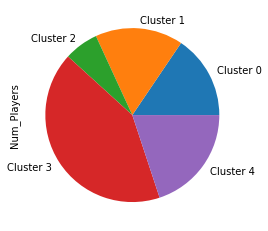

,Num_Players
Cluster 0,39
Cluster 1,41
Cluster 2,16
Cluster 3,105
Cluster 4,50


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,RA Jadeja,PA Patel,RG Sharma,STR Binny,KM Jadhav
1,DJ Bravo,MK Pandey,SK Raina,KH Pandya,SS Tiwary
2,Harbhajan Singh,Yuvraj Singh,V Kohli,LRPL Taylor,S Badrinath
3,IK Pathan,BB McCullum,RV Uthappa,Y Venugopal Rao,EJG Morgan
4,PP Chawla,M Vijay,MS Dhoni,AM Nayar,Ishan Kishan
5,AR Patel,V Sehwag,KD Karthik,DJ Hooda,M Vohra
6,JA Morkel,SV Samson,S Dhawan,TM Dilshan,CA Lynn
7,SP Narine,WP Saha,AB de Villiers,MC Henriques,MS Bisla
8,P Kumar,JH Kallis,YK Pathan,Shakib Al Hasan,PP Shaw
9,R Ashwin,NV Ojha,G Gambhir,CL White,Shubman Gill


(           Num_Players
 Cluster 0           39
 Cluster 1           41
 Cluster 2           16
 Cluster 3          105
 Cluster 4           50,
            Cluster 0         Cluster 1       Cluster 2        Cluster 3  \
 0          RA Jadeja          PA Patel       RG Sharma        STR Binny   
 1           DJ Bravo         MK Pandey        SK Raina        KH Pandya   
 2    Harbhajan Singh      Yuvraj Singh         V Kohli      LRPL Taylor   
 3          IK Pathan       BB McCullum      RV Uthappa  Y Venugopal Rao   
 4          PP Chawla           M Vijay        MS Dhoni         AM Nayar   
 5           AR Patel          V Sehwag      KD Karthik         DJ Hooda   
 6          JA Morkel         SV Samson        S Dhawan       TM Dilshan   
 7          SP Narine           WP Saha  AB de Villiers     MC Henriques   
 8            P Kumar         JH Kallis       YK Pathan  Shakib Al Hasan   
 9           R Ashwin           NV Ojha       G Gambhir         CL White   
 10          A Mish

In [404]:

# View the summary of the clustering
clustering_summary(kmeans_label)

In [405]:
#dbscan_clustering(0.8,5,players_scaled[ALL_COLUMN_NAMES],players,"cluster_dbscan")

In [406]:
# # Compute DBSCAN
# db = DBSCAN(eps=0.3, min_samples=5).fit(players_scaled)
# labels = db.labels_

# # assign cluster labels
# players['cluster_dbscan'] = labels


In [407]:
# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)

In [408]:
# groupby_cluster("cluster_dbscan",5)

# Comparing clustering results

In [409]:
print(f"K-means clustering with k={NUM_CLUSTERS}")
print(players['cluster_kmeans'].value_counts())
print(f"\nHierarchical clustering with k={NUM_CLUSTERS}")
print(players['cluster_hier'].value_counts())
print(f"\nDBScan clustering")
print(players['cluster_dbscan'].value_counts())

K-means clustering with k=5
Cluster 3    105
Cluster 4     50
Cluster 1     41
Cluster 0     39
Cluster 2     16
Name: cluster_kmeans, dtype: int64

Hierarchical clustering with k=5
Cluster 0    188
Cluster 1     29
Cluster 2     16
Cluster 3     14
Cluster 4      4
Name: cluster_hier, dtype: int64

DBScan clustering
-1    162
 0     39
 1     31
 2      8
 4      6
 3      5
Name: cluster_dbscan, dtype: int64


In [410]:
players.groupby(['cluster_dbscan']).head().sort_values(by='cluster_dbscan')

,name,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,player_of_match,cluster_kmeans,cluster_hier,cluster_dbscan
A Kumble,A Kumble,42.0,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0,Cluster 3,Cluster 1,-1
A Mishra,A Mishra,150.0,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3233.0,160.0,529.0,3867.0,7.31,21.0,11.0,Cluster 0,Cluster 2,-1
A Nehra,A Nehra,88.0,63.0,17.0,41.0,3.0,1.0,2.41,65.08,1974.0,106.0,320.0,2495.0,7.80,19.0,6.0,Cluster 0,Cluster 1,-1
A Symonds,A Symonds,36.0,781.0,36.0,974.0,74.0,41.0,27.06,124.71,540.0,20.0,88.0,674.0,7.66,21.0,3.0,Cluster 3,Cluster 0,-1
AB Agarkar,AB Agarkar,42.0,160.0,18.0,179.0,13.0,5.0,9.94,111.87,820.0,29.0,131.0,1151.0,8.79,5.0,0.0,Cluster 3,Cluster 0,-1
A Ashish Reddy,A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0,Cluster 3,Cluster 0,0
AS Raut,AS Raut,17.0,172.0,16.0,194.0,13.0,7.0,12.12,112.79,30.0,0.0,5.0,44.0,8.80,9.0,0.0,Cluster 3,Cluster 0,0
AL Menaria,AL Menaria,25.0,367.0,23.0,401.0,24.0,18.0,17.43,109.26,113.0,3.0,19.0,144.0,7.58,5.0,0.0,Cluster 3,Cluster 0,0
AA Jhunjhunwala,AA Jhunjhunwala,19.0,218.0,15.0,217.0,19.0,5.0,14.47,99.54,88.0,1.0,15.0,129.0,8.60,10.0,1.0,Cluster 3,Cluster 0,0
AD Mascarenhas,AD Mascarenhas,13.0,79.0,11.0,79.0,5.0,1.0,7.18,100.00,310.0,19.0,52.0,356.0,6.85,3.0,1.0,Cluster 3,Cluster 0,0


# Plots

## Runs vs Wickets

In [411]:
def plot_clusters(x,y,cluster_col,size):
    fig = px.scatter(players, x=x,   y=y, color=cluster_col,
                     size=size, hover_data=['name'], title = f'Scatter Plot: {x} vs {y}, Size = {size}', color_discrete_sequence=px.colors.qualitative.Light24)
    fig.show()

In [412]:
plot_clusters('runs','wickets','cluster_kmeans','catches')

In [413]:
plot_clusters('runs','wickets','cluster_hier','catches')

In [414]:
plot_clusters('runs','wickets','cluster_dbscan','catches')

In [415]:
# # Plotly scatter plot
# fig = px.scatter(players, x="runs",   y="wickets", color="cluster_kmeans",
#                  size='catches', hover_data=['name'], title = 'Scatter Plot: Runs vs Wickets, Size = catches', color_discrete_sequence=px.colors.qualitative.Light24)
# fig.show()

# # color_discrete_sequence - https://plotly.com/python/discrete-color/

## Seaborn - scatter plots

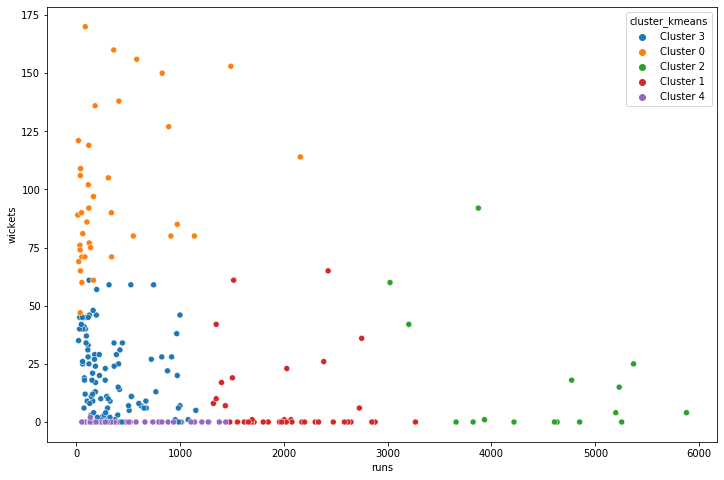

In [416]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_kmeans", data=players, palette="tab10")

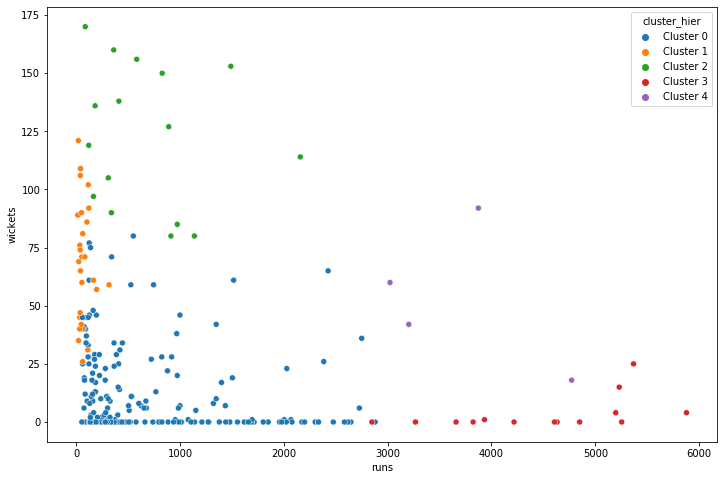

In [417]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_hier", data=players, palette="tab10")

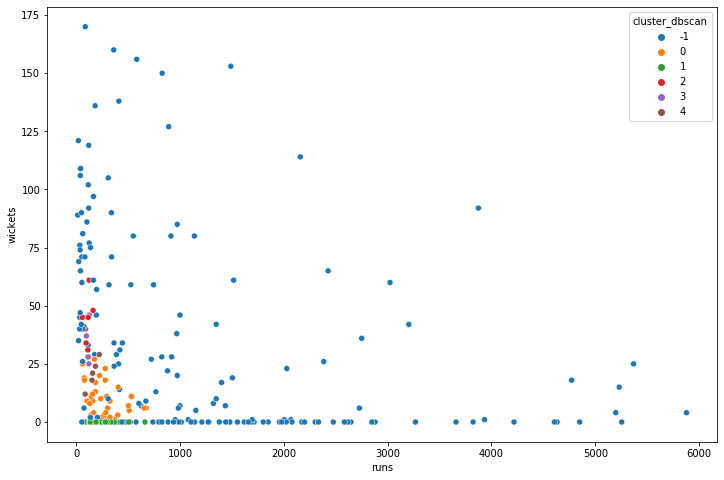

In [418]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="wickets", hue="cluster_dbscan", data=players, palette="tab10")

## Runs vs catches

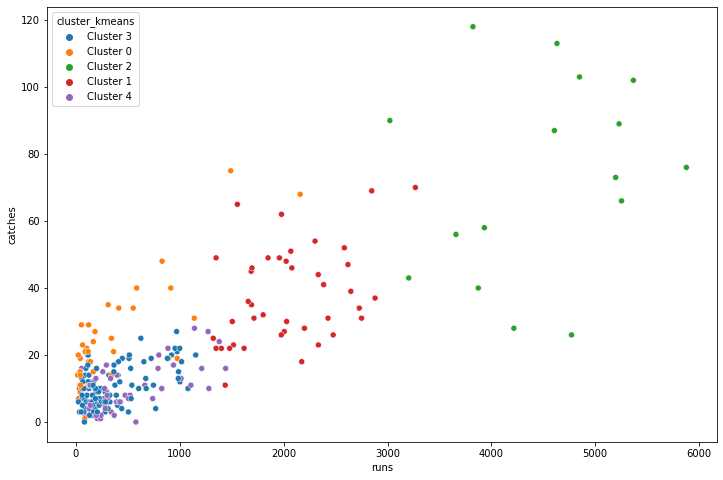

In [419]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="runs",   y="catches", hue="cluster_kmeans", data=players, palette="tab10")

# Only runs & wickets

In [420]:
cols = ['bat_average','bowl_econ']

In [421]:
# final model with k=3
kmeans = KMeans(n_clusters=NUM_CLUSTERS, max_iter=50)
kmeans.fit(players_scaled[cols])

# assign the label
players['cluster_kmeans_small'] = kmeans.labels_


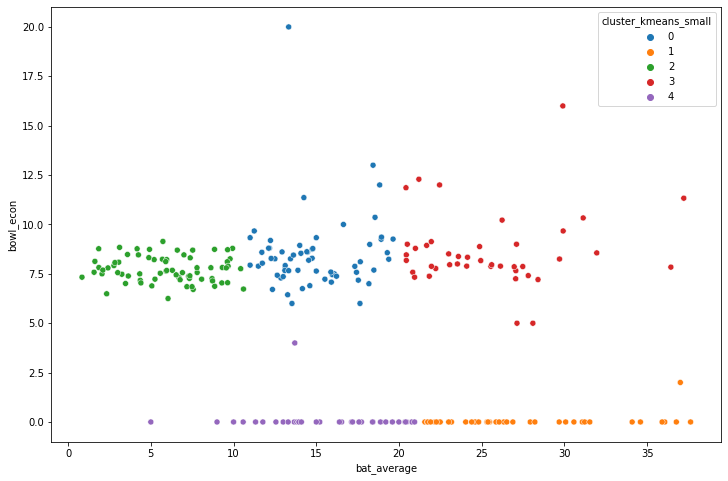

In [422]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="bat_average",   y="bowl_econ", hue="cluster_kmeans_small", data=players, palette="tab10")

In [423]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(players_scaled[cols])
labels = db.labels_

# assign cluster labels
players['cluster_dbscan_avgecon'] = labels

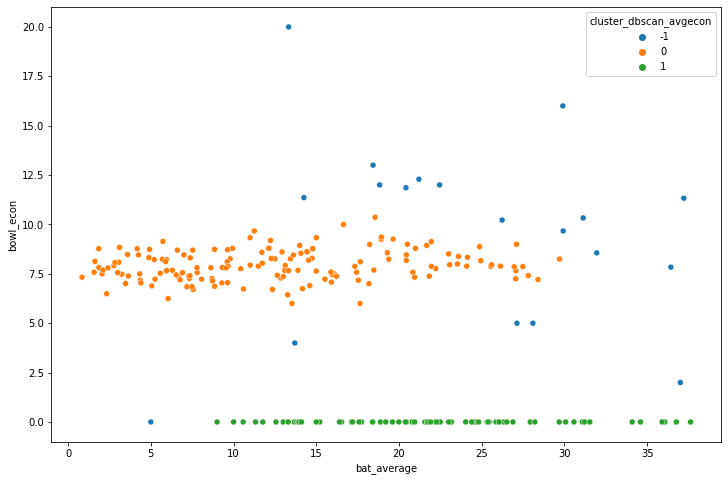

In [424]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="bat_average",   y="bowl_econ", hue="cluster_dbscan_avgecon", data=players, palette="tab10")

# References

In [425]:
# https://www.linkedin.com/pulse/ai-daily-life-clustering-cricket-players-ramachandran-s/
    

# WIDGETS

In [426]:
b_with_kvalue = True
config_layout = widgets.Layout(width= 'max-content', height='40px',justify_content='space-between',display='flex',
    flex_flow='column', align_items='stretch' )

widgets.IntSlider(
    value=5, min=2, max=10, step=1,
    description='No. of clusters:',
    disabled=not b_with_kvalue, layout=config_layout )

IntSlider(value=5, description='No. of clusters:', layout=Layout(align_items='stretch', display='flex', flex_f…

In [427]:
config_layout = widgets.Layout(width='auto', height='40px',
    display='flex',
    flex_flow='column',
    align_items='stretch') #set width and height

button = widgets.Button(
    description='Test button with some text.',
    disabled=False, 
    layout = config_layout
)        
display(button)

Button(description='Test button with some text.', layout=Layout(align_items='stretch', display='flex', flex_fl…

In [428]:
# Default Values
CLUSTERING_TECHNIQUE = 'K-MEANS CLUSTERING'
CLUSTER_COLS = ALL_COLUMN_NAMES
CLUSTER_OUTPUT_COL = 'output_kmeans'
NUM_CLUSTERS = 5
b_with_kvalue = True


############## Initialize Widgets ###################
w_ctechnique = widgets.Dropdown(options=['K-MEANS CLUSTERING', 'HIERARCHICAL CLUSTERING', 'DBSCAN CLUSTERING'],
                                         value=CLUSTERING_TECHNIQUE, description='Clustering Technique:',
                                         style={'description_width': 'initial'}, disabled=False)

# config_layout = widgets.Layout(  width='auto', height='40px',justify_content='space-between',display='flex',
#     flex_flow='column', align_items='stretch' )
# No. of clusters
w_kvalue = widgets.IntSlider(
    value=5, min=2, max=10, step=1, description='', disabled=not b_with_kvalue )


w_epsilon = widgets.FloatSlider(
    value=0.3, min=0, max=5.0, step=0.1, description='',
    disabled=b_with_kvalue, continuous_update=False, orientation='horizontal',
    readout=True, readout_format='.1f',
    visibility = False
)

w_minpoints = widgets.IntSlider(
    value=5, min=2, max=20, step=1, description='', disabled=b_with_kvalue,
    visibility = False )

multiselect_layout = widgets.Layout(width='40%')
w_ccolumns = widgets.SelectMultiple(options=ALL_COLUMN_NAMES, description='Select columns to cluster on:',
                                        value=CLUSTER_COLS,
                                        style={'description_width': 'initial'}, disabled=False)


                                         
button_layout = widgets.Layout(display='flex', flex_flow='column', align_items='stretch', border='solid',
                               width='40%', height='40px')
wbtn_cluster_data = widgets.Button(description="CLUSTER PLAYERS", disabled=False, layout=button_layout,
                                     visibility="visible", button_style="success")
#wbtn_optimal_k = widgets.Button(description="FIND OPTIMAL K", disabled=False,
#                                       layout=button_layout,
#                                       visibility="visible", button_style="success")
output_clusters = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
output_plot = widgets.Output(layout=widgets.Layout(border='solid', width='100%'))
         
                                         

############## Observe Widgets ###################
def create_clusters(): 
    global CLUSTER_OUTPUT_COL
    if(w_ctechnique.value == 'K-MEANS CLUSTERING'):
        NUM_KMEANS_ITER = 50
        CLUSTER_OUTPUT_COL = 'output_kmeans'
        kmeans_clustering(NUM_CLUSTERS,NUM_KMEANS_ITER,CLUSTER_COLS,CLUSTER_OUTPUT_COL)
    elif(w_ctechnique.value == 'HIERARCHICAL CLUSTERING'):
        LINKAGE_METHOD = 'complete' #'single'
        LINKAGE_METRIC = 'euclidean'  
        CLUSTER_OUTPUT_COL = 'output_hier'
        mergings = hierarchical_clustering(LINKAGE_METHOD, LINKAGE_METRIC, NUM_CLUSTERS, CLUSTER_COLS,CLUSTER_OUTPUT_COL)      
    elif(w_ctechnique.value == 'DBSCAN CLUSTERING'):
        CLUSTER_OUTPUT_COL = 'output_dbscan'
        dbscan_clustering(w_epsilon.value,w_minpoints.value,CLUSTER_COLS,CLUSTER_OUTPUT_COL)
                                         
# Set values on observe

def set_cluster_technique( b):
    CLUSTERING_TECHNIQUE = w_ctechnique.value
    if((w_ctechnique.value == 'K-MEANS CLUSTERING') or (w_ctechnique.value == 'HIERARCHICAL CLUSTERING')):
        b_with_kvalue = True 
#         w_kvalue.layout.visibility = 'visible'
#         w_epsilon.layout.visibility = 'hidden'
#         w_minpoints.layout.visibility = 'hidden'
    else:
        b_with_kvalue = False
#         w_kvalue.layout.visibility = 'hidden'
#         w_epsilon.layout.visibility = 'visible'
#         w_minpoints.layout.visibility = 'visible'
    w_kvalue.disabled = not b_with_kvalue
    w_epsilon.disabled = b_with_kvalue
    w_minpoints.disabled = b_with_kvalue

def set_cluster_columns(b):
    global CLUSTER_COLS
    CLUSTER_COLS = list(w_ccolumns.value)
    
def set_kvalue(b):
    global NUM_CLUSTERS
    NUM_CLUSTERS = w_kvalue.value
    
                                         
def on_cluster_players(b):
    output_clusters.clear_output()
    output_plot.clear_output()
    create_clusters()  
    with output_clusters:
        groupby_cluster(CLUSTER_OUTPUT_COL,5)
    with output_plot: 
        if(w_ctechnique == 'HIERARCHICAL CLUSTERING'):
            dendrogram(mergings)
            plt.show()
        plot_clusters('runs','wickets',CLUSTER_OUTPUT_COL,'catches')
        

w_ctechnique.observe(set_cluster_technique, names='value')
w_kvalue.observe(set_kvalue, names='value')
w_ccolumns.observe(set_cluster_columns, names='value') 

wbtn_cluster_data.on_click(on_cluster_players) 
############## View Widgets ###################



display(widgets.VBox(
    [widgets.Label("ENTER CONFIGURATIONS"),  w_ctechnique,
     widgets.HBox([widgets.Label("Number of Clusters:"), w_kvalue],width='auto'),
     widgets.HBox([widgets.Label("DBScan Epsilon:"), w_epsilon,widgets.Label("DBScan Minimum Points:"),w_minpoints]), 
     w_ccolumns]))
display(widgets.HBox([wbtn_cluster_data]))
# display(widgets.VBox([self.wbtn_create_team]))
display(output_plot)    
display(output_clusters)                                     
                                

Output(layout=Layout(border='solid', width='100%'))

Output(layout=Layout(border='solid', width='100%'))

# TESTING

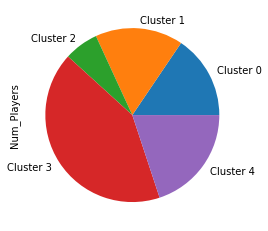

,Num_Players
Cluster 0,39
Cluster 1,41
Cluster 2,16
Cluster 3,105
Cluster 4,50


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,RA Jadeja,PA Patel,RG Sharma,STR Binny,KM Jadhav
1,DJ Bravo,MK Pandey,SK Raina,KH Pandya,SS Tiwary
2,Harbhajan Singh,Yuvraj Singh,V Kohli,LRPL Taylor,S Badrinath
3,IK Pathan,BB McCullum,RV Uthappa,Y Venugopal Rao,EJG Morgan
4,PP Chawla,M Vijay,MS Dhoni,AM Nayar,Ishan Kishan
5,AR Patel,V Sehwag,KD Karthik,DJ Hooda,M Vohra
6,JA Morkel,SV Samson,S Dhawan,TM Dilshan,CA Lynn
7,SP Narine,WP Saha,AB de Villiers,MC Henriques,MS Bisla
8,P Kumar,JH Kallis,YK Pathan,Shakib Al Hasan,PP Shaw
9,R Ashwin,NV Ojha,G Gambhir,CL White,Shubman Gill


In [429]:
clsum,cldf = clustering_summary("cluster_kmeans") 

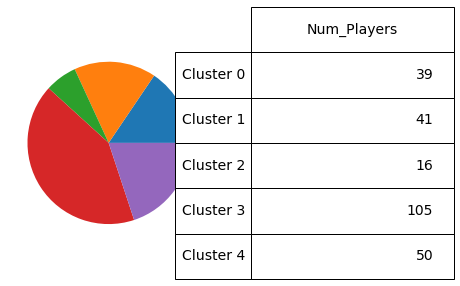

In [430]:
import matplotlib.pyplot as plt
#from matplotlib import six
import pandas as pd
import numpy as np

df = pd.DataFrame()
df['x'] = np.arange(0,11)
df['y'] = df['x']*2

fig = plt.figure(figsize=(8,5))

ax1 = fig.add_subplot(121)
#ax1.scatter(x=df['x'],y=df['y'])
ax1.pie(clsum['Num_Players'])
#cluster_summary['Num_Players'].plot.pie()

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = clsum.values, rowLabels = clsum.index, bbox=bbox, colLabels=clsum.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)